In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
# 한글 패치 진행

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 데이터 불러오기


In [4]:
data = pd.read_csv('sampled_data/rawdata_pj1.csv')

# 데이터 전처리
- 소비를 그려서 고소비층과 저소비층으로 나누자.
- 각 그룹의 소비 패턴을 파악해야 한다.
- 소비 패턴 파악의 결과로 고소비층을 위한 프리미엄 카드와 저소비층을 위한 카드를 만들자.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123850 entries, 0 to 2123849
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   거래년월            int64 
 1   고객ID            int64 
 2   가맹점업종명          object
 3   가맹점_광역시도        object
 4   가맹점_시군구         object
 5   승인건수            object
 6   승인금액            int64 
 7   연령대             object
 8   성별              object
 9   자택_시도           object
 10  자택_시군구          object
 11  승인건수_수치화        int64 
 12  년도              int64 
 13  가맹점업종명_범주화_중분류  object
dtypes: int64(5), object(9)
memory usage: 226.9+ MB


In [53]:
'''
# 그룹화 - 나이 및 성별
# 계층적 군집화, GMM, K-means 기반

# 그룹_나이성별 칸 다시 재처리

def age_gender_group(data):
    # 연령대와 성별에 따른 그룹 매핑 딕셔너리 생성
    age_gender_mapping = {
        ('30대', '남'): 'A',
        ('40대', '남'): 'A', 
        ('40대', '여'): 'A',
        ('50대', '남'): 'B',
        ('50대', '여'): 'B',
        ('60대이상', '남'): 'B',
        ('60대이상', '여'): 'B'
    }
    
    # 연령대와 성별 조합으로 그룹 할당
    data['그룹_나이성별'] = data.apply(
        lambda x: age_gender_mapping.get(
            (x['연령대'], x['성별']), 'A'
        ),
        axis=1
    )
    
    return data

data = age_gender_group(data)
'''

In [6]:
# 시계열 분석을 위해 Datetime 형식으로 변환
data['거래년월'] = pd.to_datetime(data['거래년월'])

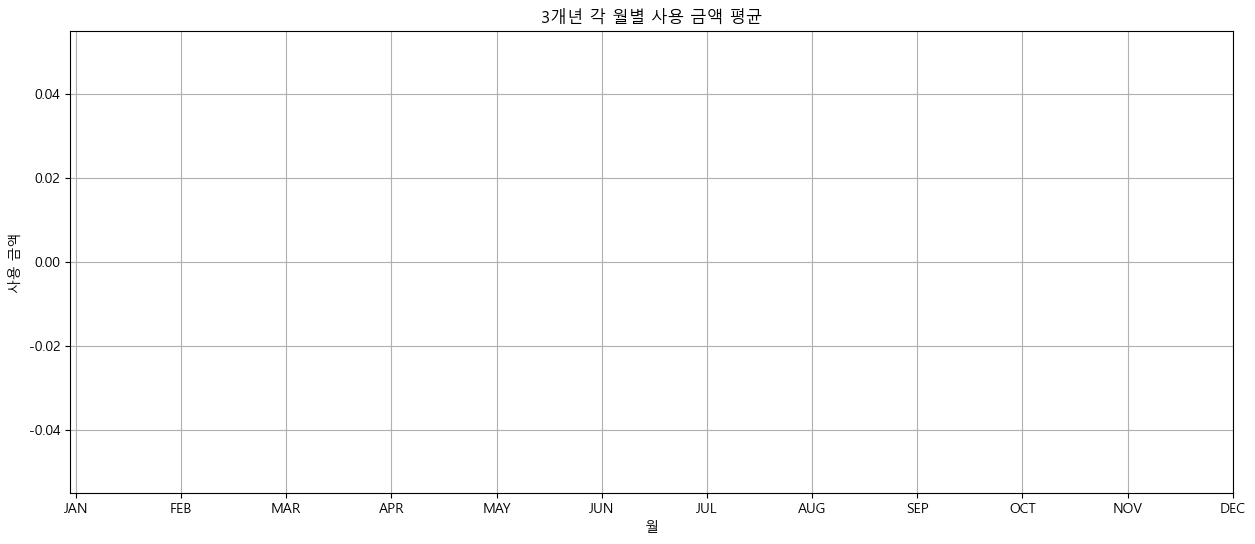

In [7]:
# 월별 순서 정의
month_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# 월별 사용금액 집계 및 순서 정렬
money_use_month = data.groupby('거래년월')['승인금액'].mean().reindex(month_order)

# 그래프 그리기
plt.figure(figsize=(15, 6))
money_use_month.plot(color='#98FF98')
plt.title('3개년 각 월별 사용 금액 평균')
plt.xlabel('월')
plt.ylabel('사용 금액')
plt.xticks(range(len(month_order)), month_order, rotation=0)
plt.grid(True)
plt.show()


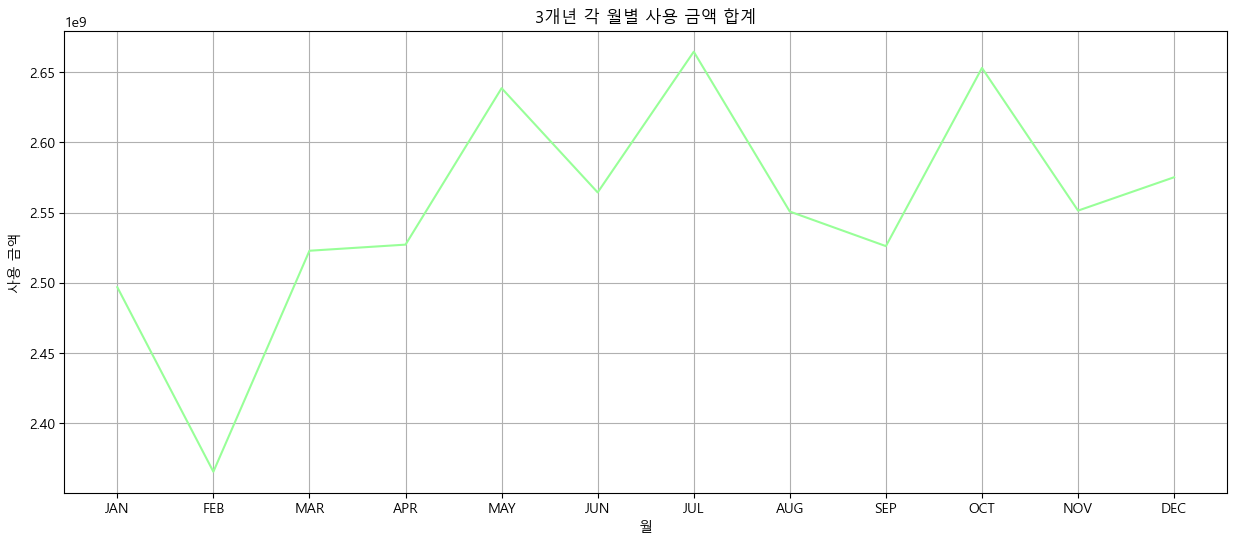

In [56]:
# 월별 순서 정의
month_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# 월별 사용금액 집계 및 순서 정렬
money_use_month = data.groupby('거래월')['승인금액'].sum().reindex(month_order)

# 그래프 그리기
plt.figure(figsize=(15, 6))
money_use_month.plot(color='#98FF98')
plt.title('3개년 각 월별 사용 금액 합계')
plt.xlabel('월')
plt.ylabel('사용 금액')
plt.xticks(range(len(month_order)), month_order, rotation=0)
plt.grid(True)
plt.show()


In [57]:
# 거래월 추출 - 실행 시 자동으로 년-월로 묶이게 된다.
data_vis = data.copy()
data_vis['거래월'] = data_vis['거래년월'].dt.to_period('M')

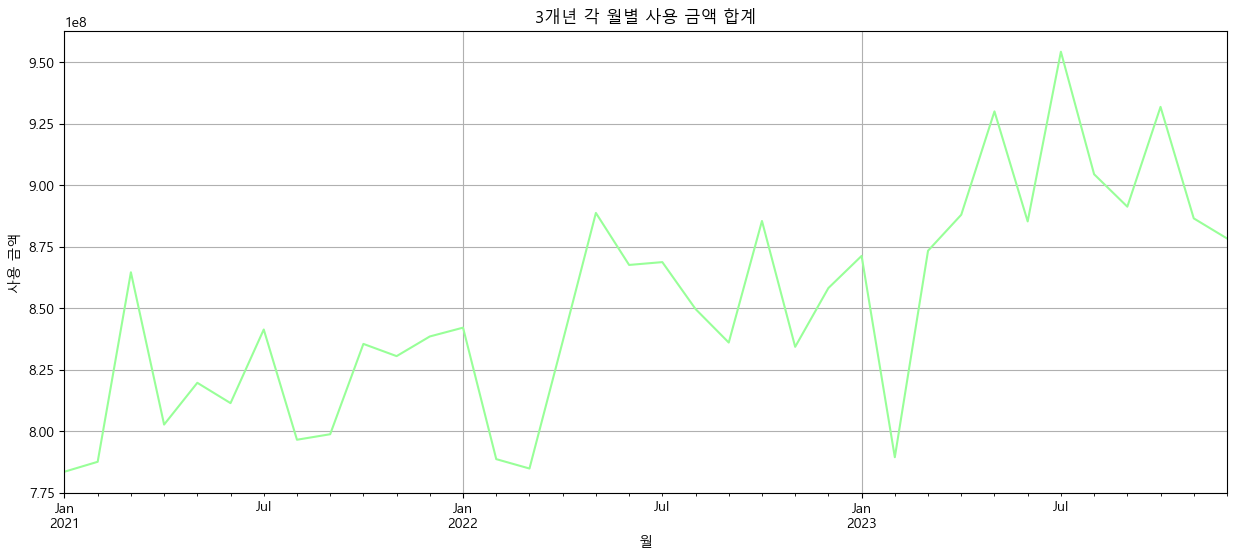

In [58]:
# 월별 사용금액 집계 및 순서 정렬
money_use_month = data_vis.groupby('거래월')['승인금액'].sum()

# 그래프 그리기
plt.figure(figsize=(15, 6))
money_use_month.plot(color='#98FF98')
plt.title('3개년 각 월별 사용 금액 합계')
plt.xlabel('월')
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()

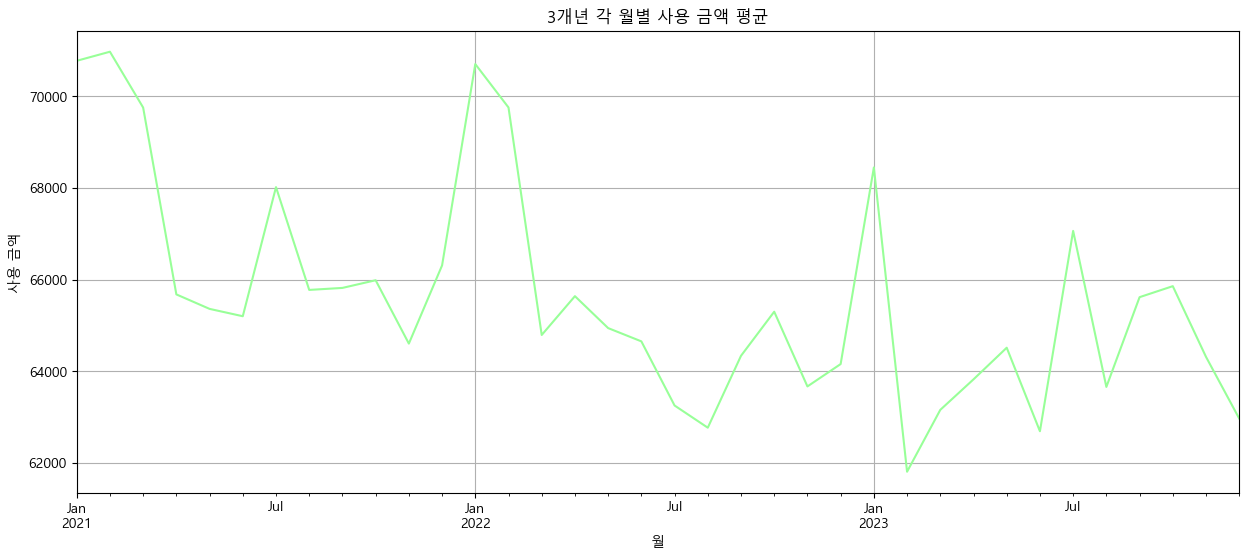

In [59]:
# 월별 사용금액 집계 및 순서 정렬
money_use_month = data_vis.groupby('거래월')['승인금액'].mean()

# 그래프 그리기
plt.figure(figsize=(15, 6))
money_use_month.plot(color='#98FF98')
plt.title('3개년 각 월별 사용 금액 평균')
plt.xlabel('월')
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()

# 그룹 나누기
- 일단 boxplot을 그려서 시각화하기
- 이후 반기별 (또는 분기별)승인 금액이 75% 이상인 사람들을 고소비층으로 나누고, 나머지를 저소비층으로 나누자.


In [60]:
# 반기 계산 (1-6월은 상반기, 7-12월은 하반기)
data['반기'] = data['거래년월'].dt.month.map(lambda x: '상반기' if x <= 6 else '하반기')

# 년도와 반기를 결합하여 새로운 컬럼 생성
data['년도_반기'] = data['거래년월'].dt.year.astype(str) + '_' + data['반기']

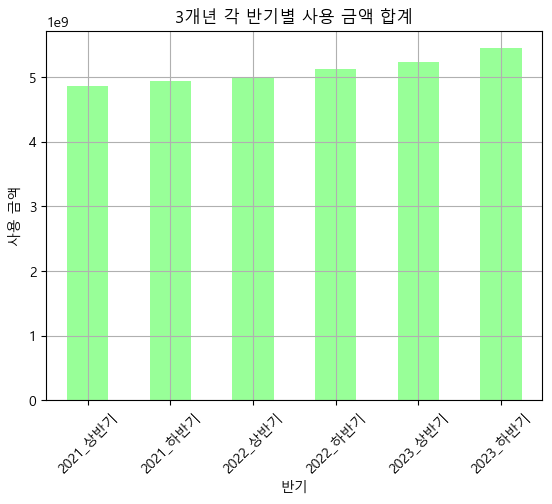

In [61]:
# 3개년 반기별 사용 금액 합계

dat_half_sum = data.groupby('년도_반기')['승인금액'].sum()
dat_half_sum.plot(kind='bar', color='#98FF98')
plt.title('3개년 각 반기별 사용 금액 합계')
plt.xlabel('반기')
plt.xticks(rotation=45)
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()


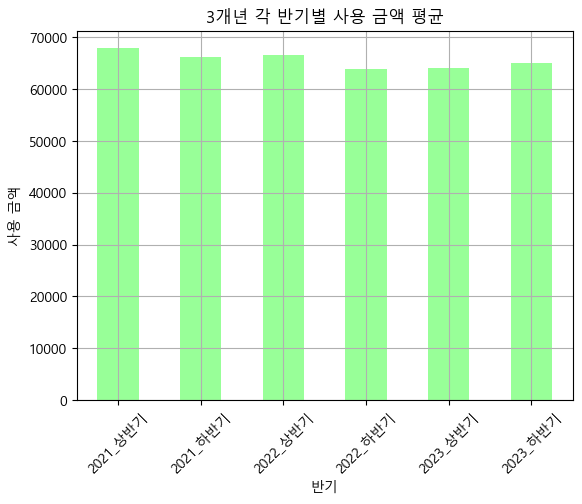

In [62]:
# 3개년 반기별 사용 금액 평균

dat_half_sum = data.groupby('년도_반기')['승인금액'].mean()
dat_half_sum.plot(kind='bar', color='#98FF98')
plt.title('3개년 각 반기별 사용 금액 평균')
plt.xlabel('반기')
plt.xticks(rotation=45)
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_27236\3900716450.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='년도_반기', y='승인금액', data=data_premium_group_q, palette='YlGn')


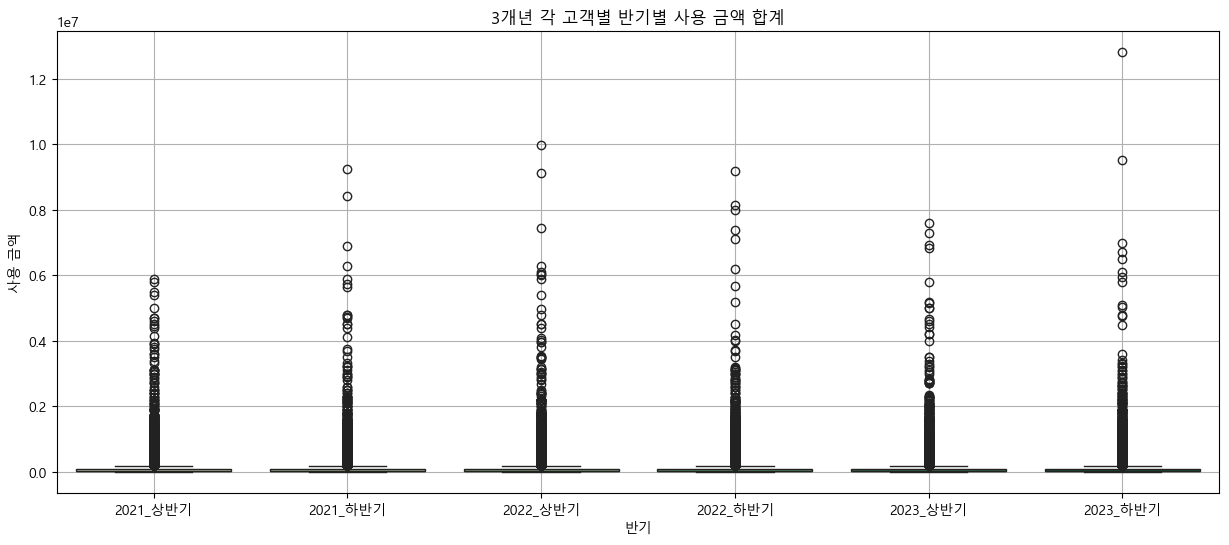

In [63]:
# 각 고객별로 년도_반기별로 사용한 금액 합계를 구하여 시각화하기 - BOXPLOT
# 이 때 고객들은 2,3,40대 인원들만 뽑음 - 5,60대 제외

data_premium_group_q = data[data['연령대'].isin(['20대', '30대', '40대'])].groupby(['고객ID', '년도_반기'])['승인금액'].sum().reset_index().sort_values(by = '년도_반기')
data_premium_group_q = pd.DataFrame(data_premium_group_q)

# Boxplot 그리기

plt.figure(figsize=(15, 6))
sns.boxplot(x='년도_반기', y='승인금액', data=data_premium_group_q, palette='YlGn')
plt.title('3개년 각 고객별 반기별 사용 금액 합계')
plt.xlabel('반기')
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()


C:\Users\campus3S031\AppData\Local\Temp\ipykernel_27236\392588684.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='년도', y='승인금액', data=data_premium_group_y, palette='YlGn')


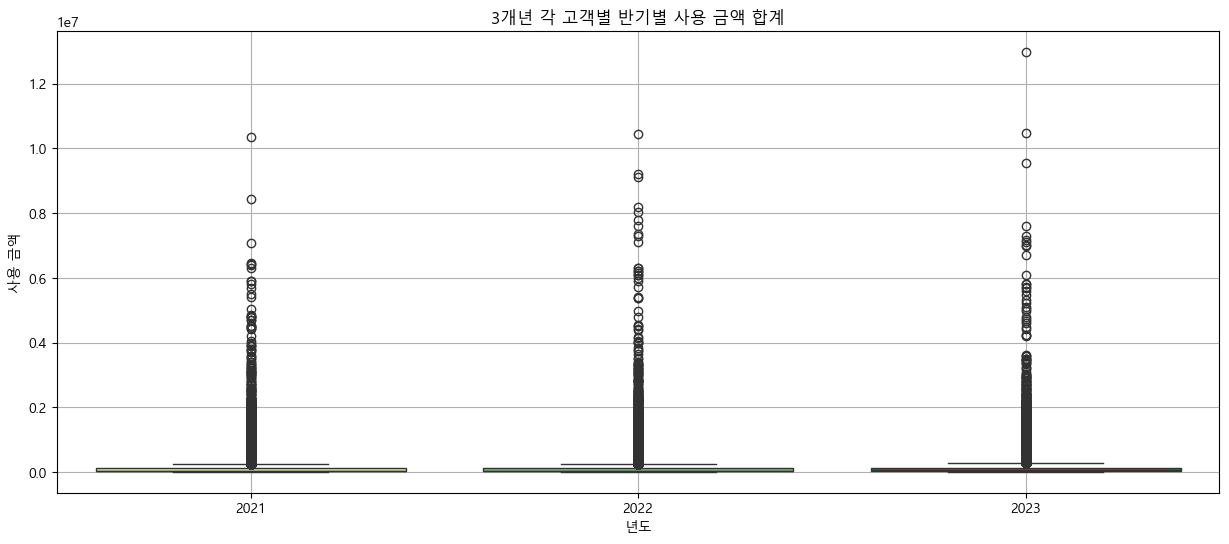

In [64]:
# 각 고객별로 년도별로 사용한 금액 합계를 구하여 시각화하기 - BOXPLOT
# 반기만 해도 이상치가 엄청 많으니 연도로 보자

data_premium_group_y = data[data['연령대'].isin(['20대', '30대', '40대'])].groupby(['고객ID', '년도'])['승인금액'].sum().reset_index()
data_premium_group_y = pd.DataFrame(data_premium_group_y)

# Boxplot 그리기

plt.figure(figsize=(15, 6))
sns.boxplot(x='년도', y='승인금액', data=data_premium_group_y, palette='YlGn')
plt.title('3개년 각 고객별 반기별 사용 금액 합계')
plt.xlabel('년도')
plt.ylabel('사용 금액')
plt.grid(True)
plt.show()

In [65]:
# 이상치가 많다 -> 꽤나 극단적임
# 프리미엄 고객을 q0.75 전부로 잡을 것인 

# 이상치 기준을 IQR 방식으로 계산 = 일단 2022하반기를 기준으로
q1 = data_premium_group_q[data_premium_group_q['년도_반기'] == '2021_하반기']['승인금액'].quantile(0.25)
q3 = data_premium_group_q[data_premium_group_q['년도_반기'] == '2021_하반기']['승인금액'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# 이상치만 추출 
outliers = data_premium_group_q[
    (data_premium_group_q['년도_반기'] == '2022_하반기') & 
    (data_premium_group_q['승인금액'] > upper_bound)
].sort_values(by='승인금액', ascending=False)

outliers.reset_index().tail(10)


,index,고객ID,년도_반기,승인금액
3084,100163,6127994208,2022_하반기,200000
3085,51523,4734587708,2022_하반기,200000
3086,104979,6290650332,2022_하반기,200000
3087,115428,6604578602,2022_하반기,200000
3088,165521,9331791723,2022_하반기,200000
3089,90972,5846901771,2022_하반기,200000
3090,158018,8596133533,2022_하반기,200000
3091,54910,4836412899,2022_하반기,200000
3092,86074,5695694264,2022_하반기,200000
3093,138615,7542433132,2022_하반기,200000


In [66]:
data[data['고객ID'] == 5695694264]

,Unnamed: 0.1,Unnamed: 0,거래년월,고객ID,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액,연령대,성별,고객등급,자택_시도,자택_시군구,승인건수_수치화,거래년월_분기,거래월,년도,가맹점업종명_범주화,가맹점_인구,자택_인구,연도_분기,금리,소비자심리지수,가맹점업종명_범주화_중분류,그룹_나이성별,그룹_지역,반기,년도_반기
175576,320470,320470,2022-03-01,5695694264,스넥,서울특별시,용산구,5번이하,40000,20대,여,일반등급,대구광역시,달서구,1,1,MAR,2022,식생활,218650,0.0,2022Q1,1.25,104.033333,식생활,A,그룹_서비스,상반기,2022_상반기
201141,367193,367193,2022-05-01,5695694264,스넥,서울특별시,용산구,5번이하,30000,20대,여,일반등급,대구광역시,달서구,1,2,MAY,2022,식생활,218650,0.0,2022Q2,1.75,101.400000,식생활,A,그룹_서비스,상반기,2022_상반기
208126,384925,384925,2022-05-01,5695694264,편 의 점,서울특별시,용산구,5번이하,10000,20대,여,일반등급,대구광역시,달서구,1,2,MAY,2022,식생활,218650,0.0,2022Q2,1.75,101.400000,식생활,A,그룹_서비스,상반기,2022_상반기
226767,414204,414204,2022-07-01,5695694264,서양음식,서울특별시,마포구,5번이하,10000,20대,여,일반등급,대구광역시,달서구,1,3,JUL,2022,식생활,364638,0.0,2022Q3,2.50,88.933333,식생활,A,그룹_식생활_소매,하반기,2022_하반기
228153,415590,415590,2022-07-01,5695694264,스넥,서울특별시,용산구,5번이하,10000,20대,여,일반등급,대구광역시,달서구,1,3,JUL,2022,식생활,218650,0.0,2022Q3,2.50,88.933333,식생활,A,그룹_서비스,하반기,2022_하반기
239408,437410,437410,2022-08-01,5695694264,미용원,서울특별시,용산구,5번이하,20000,20대,여,일반등급,대구광역시,달서구,1,3,AUG,2022,서비스_및_여가,218650,0.0,2022Q3,2.50,88.933333,서비스,A,그룹_서비스,하반기,2022_하반기
240559,438561,438561,2022-08-01,5695694264,서양음식,서울특별시,용산구,5번이하,20000,20대,여,일반등급,대구광역시,달서구,1,3,AUG,2022,식생활,218650,0.0,2022Q3,2.50,88.933333,식생활,A,그룹_서비스,하반기,2022_하반기
253873,462292,462292,2022-09-01,5695694264,서양음식,서울특별시,용산구,5번이하,30000,20대,여,일반등급,대구광역시,달서구,1,3,SEP,2022,식생활,218650,0.0,2022Q3,2.50,88.933333,식생활,A,그룹_서비스,하반기,2022_하반기
267198,485884,485884,2022-10-01,5695694264,서양음식,서울특별시,용산구,5번이하,10000,20대,여,일반등급,대구광역시,달서구,1,4,OCT,2022,식생활,218650,0.0,2022Q4,3.25,88.566667,식생활,A,그룹_서비스,하반기,2022_하반기
276225,505236,505236,2022-11-01,5695694264,PG상품권,서울특별시,중구,5번이하,30000,20대,여,일반등급,대구광역시,달서구,1,4,NOV,2022,서비스_및_여가,120437,0.0,2022Q4,3.25,88.566667,서비스,A,그룹_서비스,하반기,2022_하반기


In [24]:
q3_2 = data_premium_group_q[data_premium_group_q['년도_반기'] == '2023_상반기']['승인금액'].quantile(0.75)
q3_2

np.float64(90000.0)

## 간단 시각화 결과

- 이상치가 '지나치게' 많다!
    - 이상치 떄문에 원본의 boxplot을 관측하기 어려울 정도

- 반기당 q3가 겨우 90000원밖에 안된다??
    - 애초에 대구 고객이 대부분인데 그 사람들이 서울가서 쓴 데이터가 대부분 -> 많지 않음

- 이상치 관측 결과
    - 이상치들을 몇개 본 결과 '가구', '인터넷종합 Mall', '의원, 종합병원' 류가 대부분임
    - 이런 소비 패턴은 몇 년에 한번 정도일텐데 프리미엄 고객을 나누는데 도움이 될까?

- 대안
    - 이상치 삭제?
    - 또는 한번 결제 시 2,000,000원이 넘어가는 항목 삭제
    - 아님 원래 계획대로 일단 75%이상만 프리미엄 고객으로 분류해보되, 상위 25% 가 아닌 상위 10%를 조회 <- 일단 이것부터

## 대안 실행

In [39]:
# 데이터도 203040으로 제한해야 한다.

data = data[data['연령대'].isin(['20대', '30대', '40대'])]

In [40]:
# 반기별 승인금액 합계 기준 상위 25%만 추출
# data_premium_group_q

# 각 분기별 90% 분위수 계산
quarterly = data_premium_group_q.groupby('년도_반기')['승인금액'].transform(lambda x: x.quantile(0.90))

# 75% 분위수 이상인 고객ID 추출
premium_customers = data_premium_group_q[data_premium_group_q['승인금액'] >= quarterly]['고객ID'].unique()

# 프리미엄 고객의 데이터만 필터링
data_premium_tmp = data[data['고객ID'].isin(premium_customers)]
data_normal_tmp = data[~data['고객ID'].isin(premium_customers)]

# 행 갯수 조회
print(data_premium_tmp.shape, data_normal_tmp.shape)

(67457, 29) (188415, 29)


In [47]:
tmp = pd.DataFrame(data_premium_tmp.groupby(['고객ID', '년도_반기'])['승인금액'].sum())
tmp2 = pd.DataFrame(data_normal_tmp.groupby(['고객ID', '년도_반기'])['승인금액'].sum())

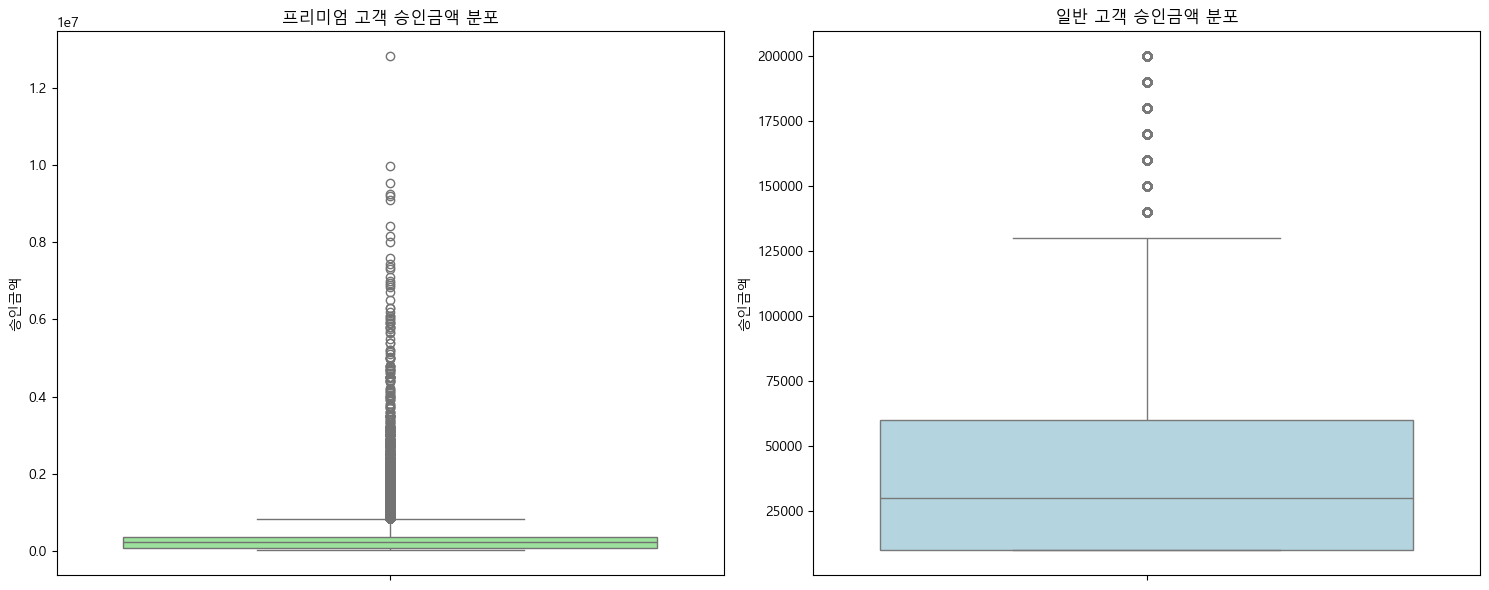

In [48]:
# 두 그룹의 boxplot을 나란히 그리기
plt.figure(figsize=(15, 6))

# 첫 번째 subplot - 프리미엄 고객
plt.subplot(1, 2, 1)
sns.boxplot(data=tmp, y='승인금액', color='lightgreen')
plt.title('프리미엄 고객 승인금액 분포')

# 두 번째 subplot - 일반 고객 
plt.subplot(1, 2, 2)
sns.boxplot(data=tmp2, y='승인금액', color='lightblue')
plt.title('일반 고객 승인금액 분포')

plt.tight_layout()
plt.show()


In [46]:
tmp.head(10)

,,승인금액
고객ID,년도_반기,
2185242638,2023_하반기,290000
2210288632,2023_하반기,250000
2225330873,2023_하반기,230000
2242059943,2023_하반기,210000
2242093950,2023_하반기,1130000
2255652414,2023_하반기,500000
2258754469,2023_하반기,690000
2280599295,2023_하반기,980000
2282895389,2023_하반기,230000


## 아이디어
- 그룹이 나뉘면 평균 사용 금액의 차이를 t-test로 확인해보자.
- 그룹의 count를 구해 anova도 해볼 수 있겠다.

## PPT 시각화 간단

In [75]:
# 의미없는 인덱스 DROP
#data = data.iloc[:,2:]

# 데이터는 2,3,40대만 
data = data[data['연령대'].isin(['20대', '30대', '40대'])]

In [76]:
data_male = data[data['성별'] == '남']
data_female = data[data['성별'] == '여']

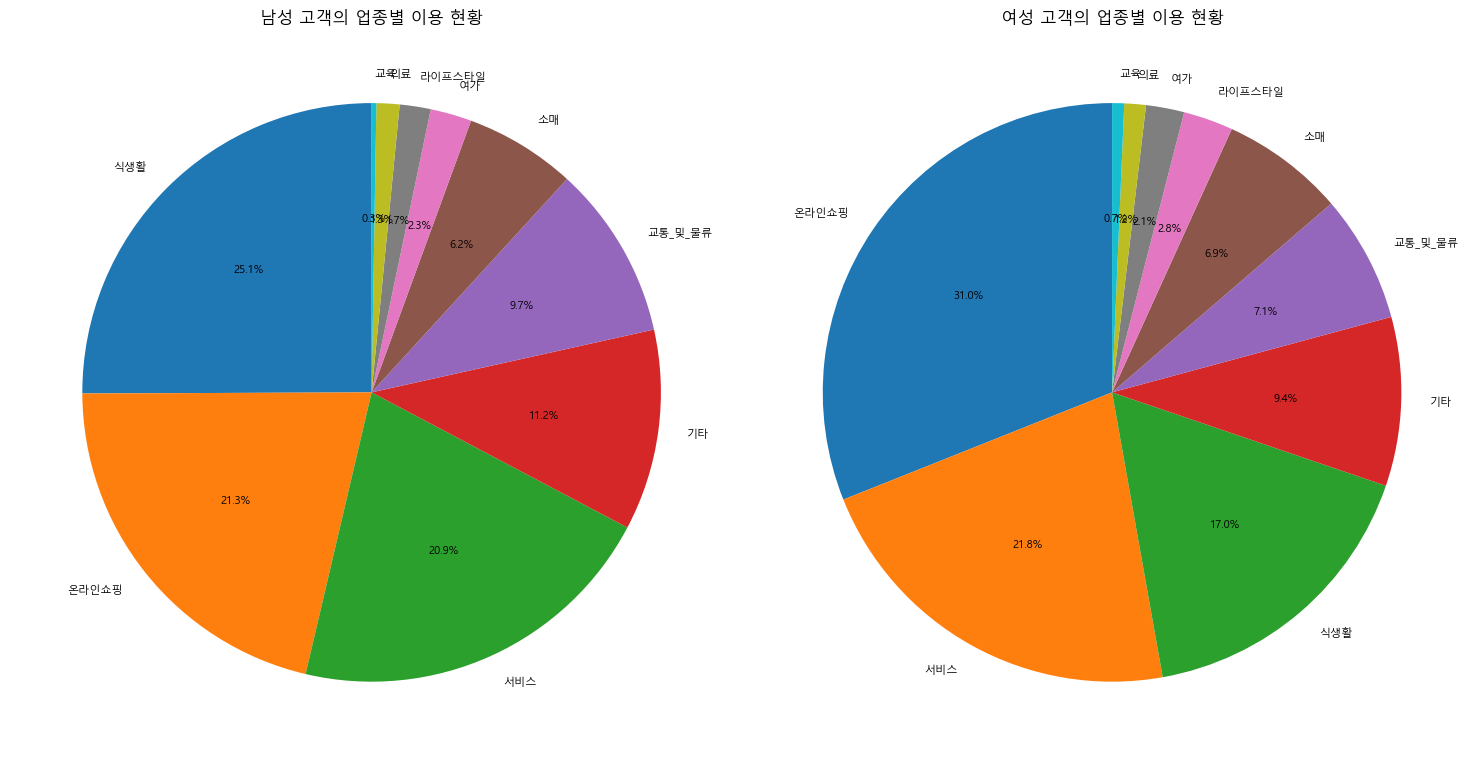

In [84]:
# 남성, 여성 고객의 업종별 이용 현황 파이차트
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.pie(data_male['가맹점업종명_범주화_중분류'].value_counts(), 
        labels=data_male['가맹점업종명_범주화_중분류'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 8})  # 글씨 크기 줄임
plt.title('남성 고객의 업종별 이용 현황')

plt.subplot(1,2,2)
plt.pie(data_female['가맹점업종명_범주화_중분류'].value_counts(), 
        labels=data_female['가맹점업종명_범주화_중분류'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 8})  # 글씨 크기 줄임
plt.title('여성 고객의 업종별 이용 현황')

plt.tight_layout()
plt.show()